# Tutorial 10 - Clustering

### Lecture and Tutorial Learning Goals:

After completing this week's lecture and tutorial work, you will be able to:

* Describe a case where clustering would be an appropriate tool, and what insight it would bring from the data.
* Explain the k-means clustering algorithm.
* Interpret the output of a k-means cluster analysis.
* Perform k-means clustering in R using `k-means`
* Visualize the output of k-means clustering in R using a scatter plot facetted across each access 
* Identify when it is necessary to scale variables before clustering and do this using R
* Use the elbow method to choose the number of clusters for k-means
* Describe advantages, limitations and assumptions of the kmeans clustering algorithm.

In [1]:
### Run this cell before continuing.
library(tidyverse)
library(repr)
library(GGally)
library(broom)
source('tests_tutorial_10.R')
source("cleanup_tutorial_10.R")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.4
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘GGally’


The following object is masked from ‘package:dplyr’:

    nasa



Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following object is masked from ‘package:tidyr’:

    matches




# 1. Pokemon

We will be working with the Pokemon dataset from Kaggle, which can be found [here.](https://www.kaggle.com/abcsds/pokemon)
This dataset compiles the statistics on 721 Pokemon. The information in this dataset includes Pokemon name, type, health points, attack strength, defensive strength, speed points etc. We are interested in seeing if there are any sub-groups/clusters of pokemon based on these statistics. And if so, how many sub-groups/clusters there are.

![](https://media.giphy.com/media/3oEduV4SOS9mmmIOkw/giphy.gif)

Source: https://media.giphy.com/media/3oEduV4SOS9mmmIOkw/giphy.gif


**Question 1.0**
<br> {points: 1}

Use `read_csv` to load `pokemon.csv` from the `data/` folder.

*Assign your answer to an object called `pm_data`.*

In [2]:
# your code here
pm_data = read_csv("data/pokemon.csv")
head(pm_data)

Parsed with column specification:
cols(
  `#` = col_double(),
  Name = col_character(),
  `Type 1` = col_character(),
  `Type 2` = col_character(),
  Total = col_double(),
  HP = col_double(),
  Attack = col_double(),
  Defense = col_double(),
  `Sp. Atk` = col_double(),
  `Sp. Def` = col_double(),
  Speed = col_double(),
  Generation = col_double(),
  Legendary = col_logical()
)



#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,FALSE
2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,FALSE
3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,FALSE
3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,FALSE
4,Charmander,Fire,NA,309,39,52,43,60,50,65,1,FALSE
5,Charmeleon,Fire,NA,405,58,64,58,80,65,80,1,FALSE


In [3]:
test_1.0()

[1] "Success!"


**Question 1.1**
<br> {points: 1}

Create a matrix of plots using `ggpairs`, choosing columns 5 to 11 (or equivalently, Total to Speed) from `pm_data`. There are several ways to do this, the most familar way would be using the select function to give a range of column names:

`data %>% select(start_column_name:end_column_name)`

Another is to pass in the column numbers to the ggpairs function as so:

`ggpairs(name_of_dataset, columns = c(number:number))`

*Assign your answer to an object called `pm_pairs`.*

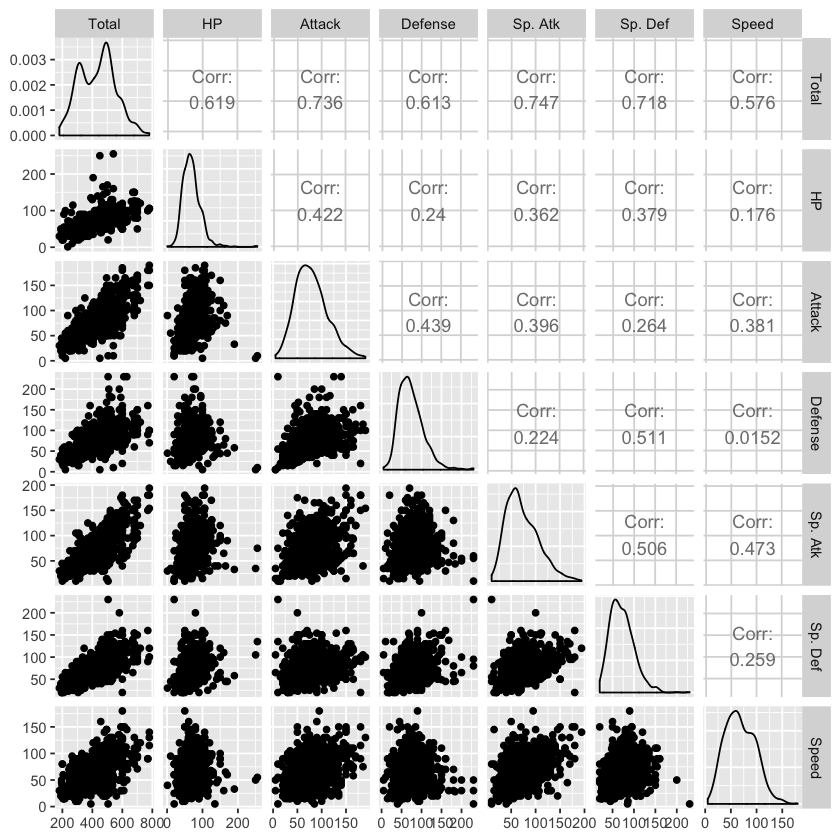

In [4]:
# your code here
pm_pairs = pm_data %>%
    select(5:11) %>%
    ggpairs()
pm_pairs

In [5]:
test_1.1()

[1] "Success!"


**Question 1.2** 
<br> {points: 1}

Make a scatterplot to visualize the relationship between `Speed` and `Defense` of the Pokemon. Put the `Speed` variable on the x-axis, and the `Defense` variable on the y-axis.

*Assign your plot to an object called `pm_scatter`. Don't forget to do everything needed to make an effective visualization.*

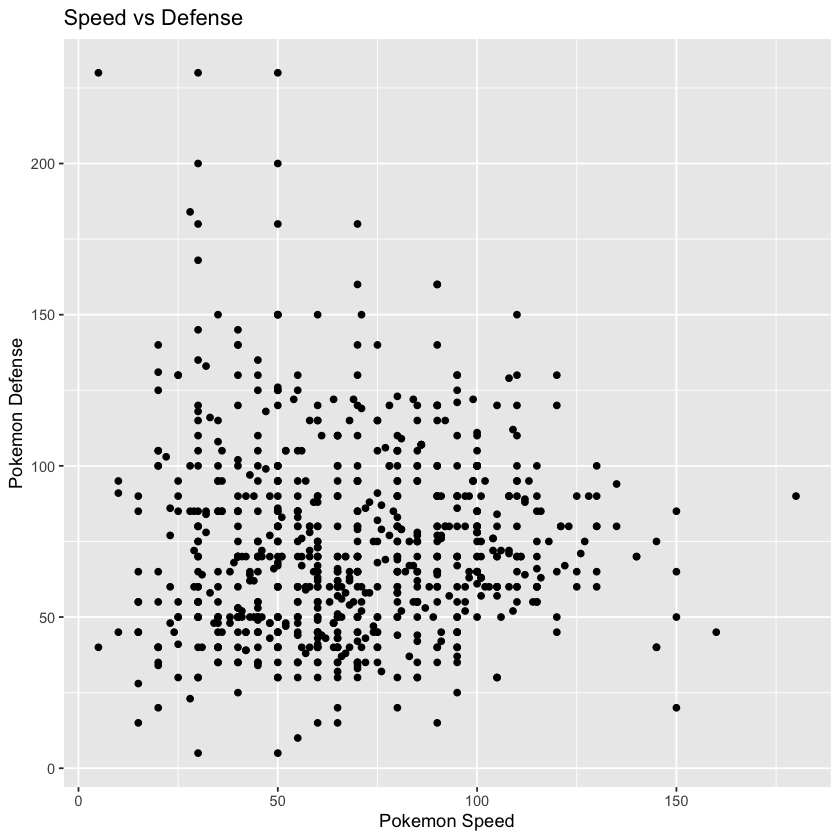

In [6]:
# your code here
pm_scatter = pm_data %>%
    select(Speed, Defense) %>%
    ggplot(aes(x = Speed, y = Defense)) +
    geom_point() +
    labs(x = "Pokemon Speed", y = "Pokemon Defense", title = "Speed vs Defense")
pm_scatter

In [7]:
test_1.2()

[1] "Success!"


**Question 1.3**
<br> {points: 1}

Select the columns `Speed` and `Defense`, creating a new dataframe with only those columns.

*Assign your answer to an object named `km_data`.*

In [8]:
# your code here
km_data = pm_data %>%
    select(Speed, Defense)
head(km_data)

Speed,Defense
<dbl>,<dbl>
45,49
60,63
80,83
80,123
65,43
80,58


In [9]:
test_1.3()

[1] "Success!"


**Question 1.4.1**
<br> {points: 3}

We are going to cluster the Pokemon based on their `Speed` and `Defense`. Will it matter much for our clustering if we scale our variables? Is there any argument against scaling here?

#### Response:

In this scenario, it is not necessary to scale our variables because their units are relatively comparable. In other words, a 1 unit increase in `Speed` is relatively similar to a 1 unit increase in `Defense`. In the end, we want the trends in our data to cluster together. Scaling could affect the clustering of these trends and create misrepresented clusters of Pokémon.

**Question 1.4.2**
<br> {points: 1}

Now, let's use the `kmeans` function to cluster the Pokemon based on their `Speed` and `Defense` variables. For this question, use K = 4.

*Assign your answer to an object called `pokemon_clusters`.*

**Note:** We set the random seed here because `kmeans` initializes observations to random clusters.

In [10]:
#DON'T CHANGE THE SEED VALUE BELOW!
set.seed(2019)

# your code here
pokemon_clusters = kmeans(km_data, centers = 4)
pokemon_clusters

K-means clustering with 4 clusters of sizes 263, 178, 104, 255

Cluster means:
      Speed   Defense
1  53.10646  45.83270
2  46.56742  83.06742
3  64.43269 131.16346
4 100.64706  72.91373

Clustering vector:
  [1] 1 1 4 3 1 4 4 4 4 2 2 3 3 1 1 1 1 1 1 4 1 1 4 4 1 4 1 4 1 4 4 4 2 3 1 2 4
 [38] 1 1 4 1 2 1 4 1 1 1 4 1 2 2 1 2 1 4 1 4 1 4 1 4 1 4 1 4 4 4 2 1 4 4 4 1 2
 [75] 2 1 1 1 1 4 2 3 3 4 4 2 2 3 2 2 1 1 4 1 2 1 2 2 3 1 4 4 4 3 1 2 2 3 4 4 2
[112] 2 2 2 4 4 2 2 3 2 3 1 3 4 4 2 4 1 1 4 4 4 4 4 4 4 4 3 4 4 4 3 2 1 1 1 4 1
[149] 2 2 3 2 3 4 4 2 4 4 4 1 1 4 4 4 4 4 2 2 4 1 4 4 2 2 3 1 4 1 1 1 4 1 2 4 1
[186] 1 1 1 1 2 2 1 4 1 1 2 2 2 1 2 2 2 1 1 4 4 1 1 4 1 2 4 3 4 2 4 1 1 4 2 3 2
[223] 3 3 3 1 2 4 2 3 3 4 3 4 1 2 1 3 1 2 2 1 2 1 2 3 1 4 4 4 1 3 2 4 1 1 2 1 4
[260] 1 4 1 4 4 3 1 2 3 3 3 4 4 1 4 4 4 1 1 4 4 1 2 2 3 1 2 1 4 1 1 1 1 2 1 1 2
[297] 1 1 4 1 4 1 2 1 1 4 4 1 1 1 2 1 4 4 2 4 1 1 1 1 1 1 1 3 1 1 2 3 2 3 2 3 3
[334] 3 1 4 4 1 4 4 4 4 4 4 1 1 2 1 4 4 1 1 1 2 2 3 1 4 1 1 1 4 1 1 1 4

In [11]:
test_1.4.2()

[1] "Success!"


**Question 1.5**
<br> {points: 1}

Let's visualize the clusters we built in `pokemon_clusters`. For this we can use the `broom` package.

> "The broom package takes the messy output of built-in functions in R, such as lm, nls, or t.test, and turns them into tidy data frames." - [Broom Package](https://cran.r-project.org/web/packages/broom/vignettes/broom.html)

Your tasks:

1. Use the `augment` function create a data frame with the cluster assignments for each data point from Kmeans (should have the columns `Speed` and `Defense` and `.cluster`). 
2. Create a scatter plot of `Speed` (x-axis) vs `Defense` (y-axis) with the points coloured by their cluster assignment. N

Name this plot `answer1.5`.

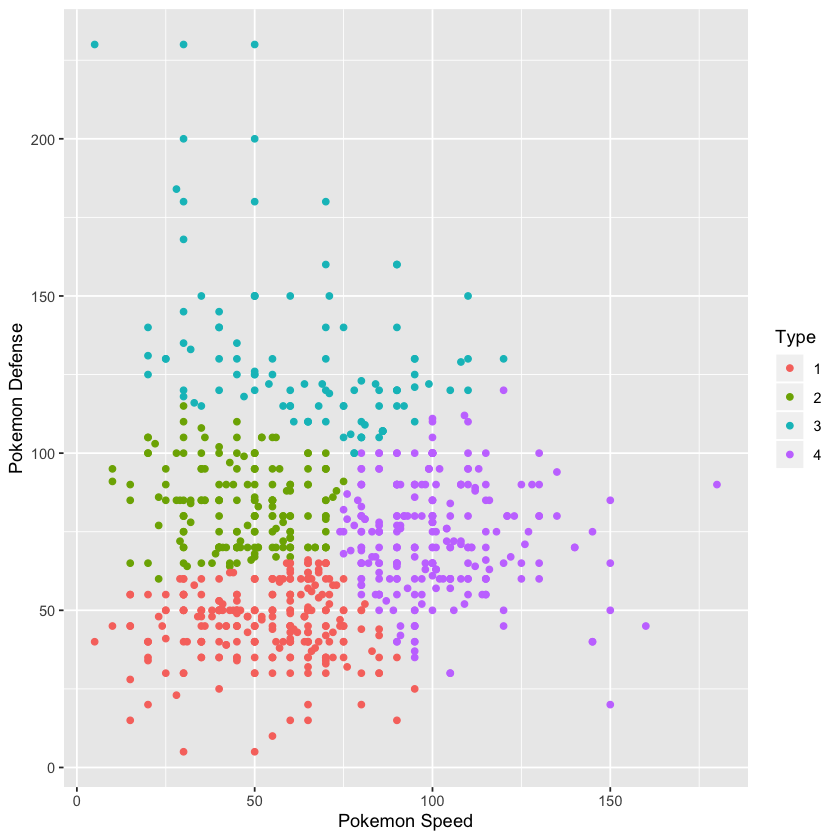

In [12]:
# your code here
answer1.5 = augment(pokemon_clusters, km_data) %>%
    ggplot(aes(x = Speed, y = Defense, color = .cluster)) +
    geom_point() +
    labs(x = "Pokemon Speed", y = "Pokemon Defense", color = "Type")
answer1.5

In [13]:
test_1.5()

[1] "Success!"


**Question 1.6**
<br> {points: 3}

Below you can see multiple initializations of k-means with different seeds for K = 4. Can you explain what is happening and how we can mitigate this in the `kmeans` function?

![](imgs/multiple_initializations.png)

#### Response:

Clustering is an unsupervised task. This means that there is no "predicted" target and that the machine learning module is performing its task without any intervention. As there is no intervention, it may arrive at any of the outcomes as seen in the matrix above.

In order to mitigate this, we can provide informative example labels called "seeds". This would, in essence, be semi-supervised learning.

**Question 1.7**
<br> {points: 1}

We know that choosing a K is an important step of the process. We can do this by examining how the total within-cluster sum of squares changes as we change K on a plot (which we call an elbow plot).

For this exercise, from K = 1 to K = 10, calculate the total within-cluster sum of squares. Set `nstart` to be 10. 

*Assign your answer to a data frame object named `elbow_stats` that has the columns `k`, `totss`, `tot.withinss`, `betweenss`, and `iter`.*

Remember, to acess the  total within-cluster sum of squares, you can use the `glance` function also from the `broom` package:

In [14]:
glance(pokemon_clusters)

totss,tot.withinss,betweenss,iter
<dbl>,<dbl>,<dbl>,<int>
1451721,475152.6,976567.9,3


In [15]:
# your code here
# ks = data.frame(k = seq(from = 1, to = 10, by = 1))
# elbow_stats = ks %>%
#     mutate(models = map(k, ~kmeans(km_data, centers = .)),
#     glanced = map(models, glance)) %>%
#     select(-models) %>%
#     unnest(glanced)

elbow_stats = tibble(k = 1:10) %>%
  mutate(model = map(k, ~kmeans(km_data, nstart = 10, .x)),
         glanced = map(model, glance)) %>%
            select(-model) %>%
            unnest(glanced)

head(elbow_stats)

k,totss,tot.withinss,betweenss,iter
<int>,<dbl>,<dbl>,<dbl>,<int>
1,1451721,1451720.6,-4.190952e-09,1
2,1451721,945092.7,5.066279e+05,1
3,1451721,582854.6,8.688660e+05,3
4,1451721,475150.8,9.765698e+05,3
5,1451721,384116.9,1.067604e+06,4
6,1451721,314871.8,1.136849e+06,4


In [16]:
test_1.7()

[1] "Success!"


**Question 1.8**
<br> {points: 3}

Create the elbow plot. Put the within-cluster sum of squares on the y-axis, and the number of clusters on the x-axis.

*Assign your plot to an object called `elbow_plot`*

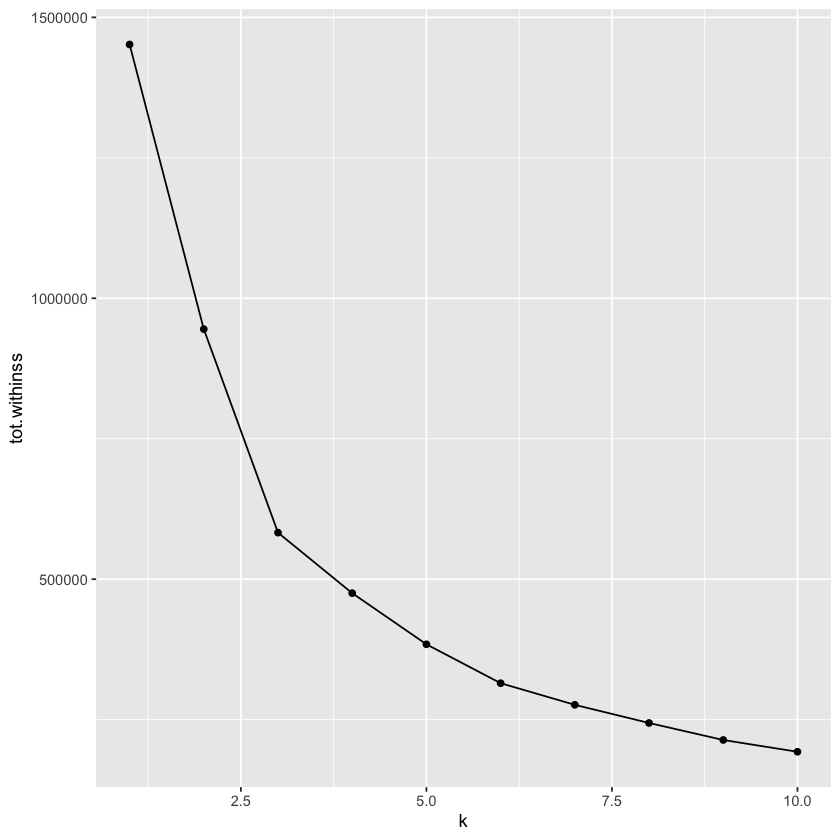

In [17]:
# your code here
elbow_plot = elbow_stats %>%
    ggplot(aes(x = k, y = tot.withinss)) + 
    geom_point() + geom_line()
elbow_plot

**Question 1.9** 
<br> {points: 3}

Based on the elbow plot above, what value of k do you choose? Explain why.

#### Response: 

I chose k = 3. While this is not entirely scientific, I chose this value as it was the point immediately before the negative slope began to decrease.

**Question 1.10**
<br> {points: 3}

Using the value that you chose for k, perform the k-means algorithm and create a plot to visualize the clusters. Again, set `nstart` to be 10, and set the seed to be 2019.

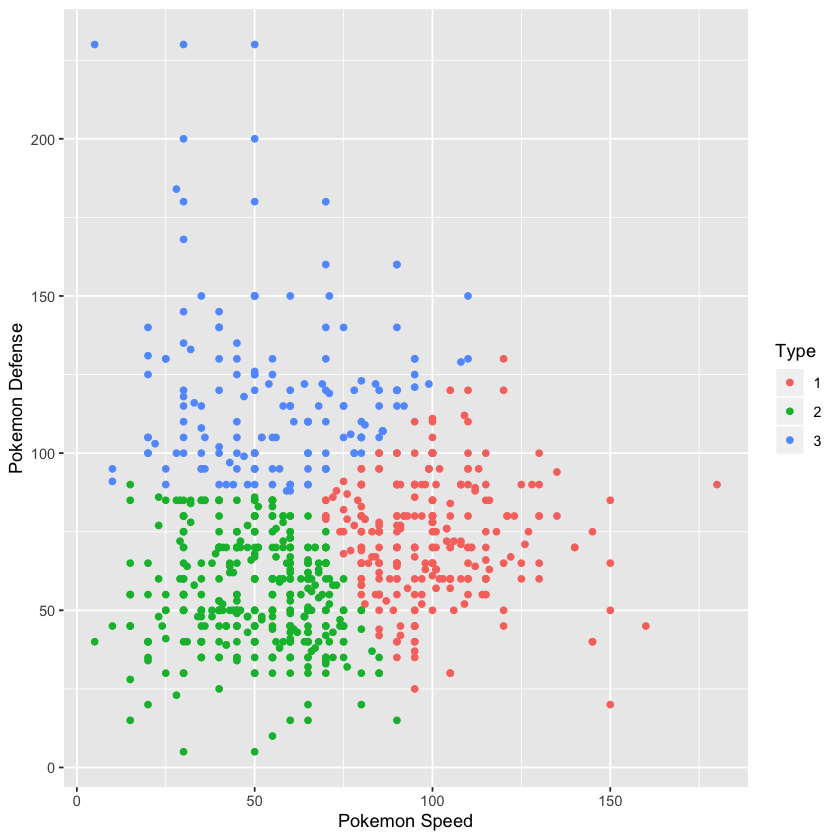

In [18]:
# your code here
set.seed(2019)

new_pokemon_clusters = kmeans(km_data, nstart = 10, centers = 3) %>%
    augment(km_data) %>%
    ggplot(aes(x = Speed, y = Defense, color = .cluster)) +
    geom_point() +
    labs(x = "Pokemon Speed", y = "Pokemon Defense", color = "Type")
new_pokemon_clusters

**Question 1.11**
<br> {points: 3}

Using `Speed` and `Defense`, we find 3 clusters of pokemon. However, we have more information in our dataset that might be useful for clustering. Let's incorporate all of the numeric values to our kmeans model. Again use `nstart = 10`.

Your tasks:

1. Select the numeric values only. For example, do not include the `#` or `Generation` columns (they are not pokemon statistics). 
2. Use the elbow plot method to determine the number of clusters.
3. Train a k-means model with the number of clusters determined in (2).
4. Print the cluster means for the trained model.

[1] "selecting k = 3"


,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
1,472.9666,77.19280,85.30077,80.95373,77.54499,79.02057,72.95373
2,622.5691,88.91057,117.72358,100.65854,116.33333,101.86179,97.08130
3,303.8958,50.14931,53.95486,52.78472,47.85417,49.49306,49.65972


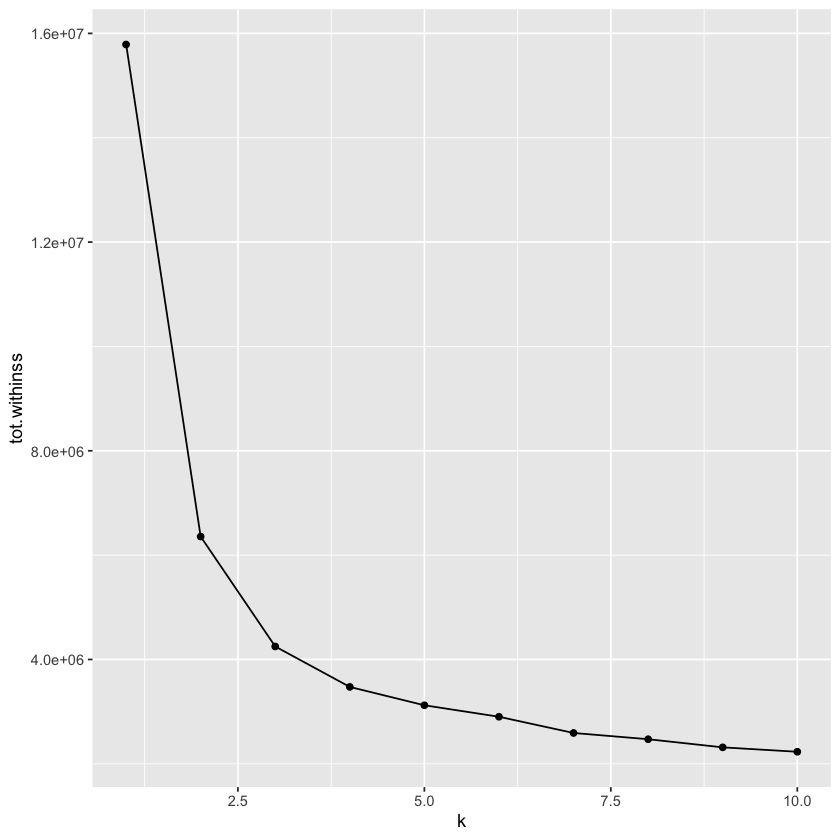

In [19]:
#DON'T CHANGE THIS SEED VALUE
set.seed(2019)

# your code here
pm_data_numeric_values_only = pm_data %>%
    select(5:11)

elbow_stats_all = tibble(k = 1:10) %>%
  mutate(model = map(k, ~kmeans(pm_data_numeric_values_only, nstart = 10, .x)),
         glanced = map(model, glance)) %>%
            select(-model) %>%
            unnest(glanced) %>%
            ggplot(aes(x = k, y = tot.withinss)) +
            geom_point() + geom_line() 

all_pm_clusters = pm_data_numeric_values_only %>%
    kmeans(nstart = 10, centers = 3) 


elbow_stats_all
print("selecting k = 3")
all_pm_clusters$centers

**Question 1.12**
<br> {points: 3}

Visualizing these clusters is not a simple task given the high-dimensionality of the model. But does the cluster means output help? Justify your reasoning.

#### Response:

The cluster means output does help as it allows us to view the centers of each cluster in each dimension. For instance, I could view the centers of the `HP` clusters by looking at the `HP` column. 

# 2. Tourism Reviews

![](https://media.giphy.com/media/xUNd9IsOQ4BSZPfnLG/giphy.gif)
Source: https://media.giphy.com/media/xUNd9IsOQ4BSZPfnLG/giphy.gif

The Ministry of Land, Infrastructure, Transport and Tourism of Japan is interested in knowing the type of tourists that visit East Asia. They know the [majority of their visitors come from this region](https://statistics.jnto.go.jp/en/graph/) and would like to stay competitive in the region to keep growing the tourism industry. For this, they have hired us to perform segmentation of the tourists. A [dataset from TripAdvisor](https://archive.ics.uci.edu/ml/datasets/Travel+Reviews) has been scraped and it's provided to you.

This dataset contains the following variables:

- User ID : Unique user id 
- Category 1 : Average user feedback on art galleries 
- Category 2 : Average user feedback on dance clubs 
- Category 3 : Average user feedback on juice bars 
- Category 4 : Average user feedback on restaurants 
- Category 5 : Average user feedback on museums 
- Category 6 : Average user feedback on resorts 
- Category 7 : Average user feedback on parks/picnic spots 
- Category 8 : Average user feedback on beaches 
- Category 9 : Average user feedback on theaters 
- Category 10 : Average user feedback on religious institutions

**Question 2.0**
<br> {points: 3}

Load the data set from https://archive.ics.uci.edu/ml/machine-learning-databases/00484/tripadvisor_review.csv and clean it so that only the Category # columns are in the data frame (i.e., remove the User ID column). 

In [20]:
# your code here
jp_tourism = read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00484/tripadvisor_review.csv') %>%
    select(-'User ID')
head(jp_tourism)

Parsed with column specification:
cols(
  `User ID` = col_character(),
  `Category 1` = col_double(),
  `Category 2` = col_double(),
  `Category 3` = col_double(),
  `Category 4` = col_double(),
  `Category 5` = col_double(),
  `Category 6` = col_double(),
  `Category 7` = col_double(),
  `Category 8` = col_double(),
  `Category 9` = col_double(),
  `Category 10` = col_double()
)



Category 1,Category 2,Category 3,Category 4,Category 5,Category 6,Category 7,Category 8,Category 9,Category 10
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.93,1.80,2.29,0.62,0.80,2.42,3.19,2.79,1.82,2.42
1.02,2.20,2.66,0.64,1.42,3.18,3.21,2.63,1.86,2.32
1.22,0.80,0.54,0.53,0.24,1.54,3.18,2.80,1.31,2.50
0.45,1.80,0.29,0.57,0.46,1.52,3.18,2.96,1.57,2.86
0.51,1.20,1.18,0.57,1.54,2.02,3.18,2.78,1.18,2.54
0.99,1.28,0.72,0.27,0.74,1.26,3.17,2.89,1.66,3.66


**Question 2.1**
<br> {points: 3}

Perform k-means and vary K from 1 to 10 to identify the optimal number of clusters. Create an elbow plot to help you choose K. At all steps use `nstart = 100` and do not forget to set a seed. 

Selecting k = 3 after looking at the chart...



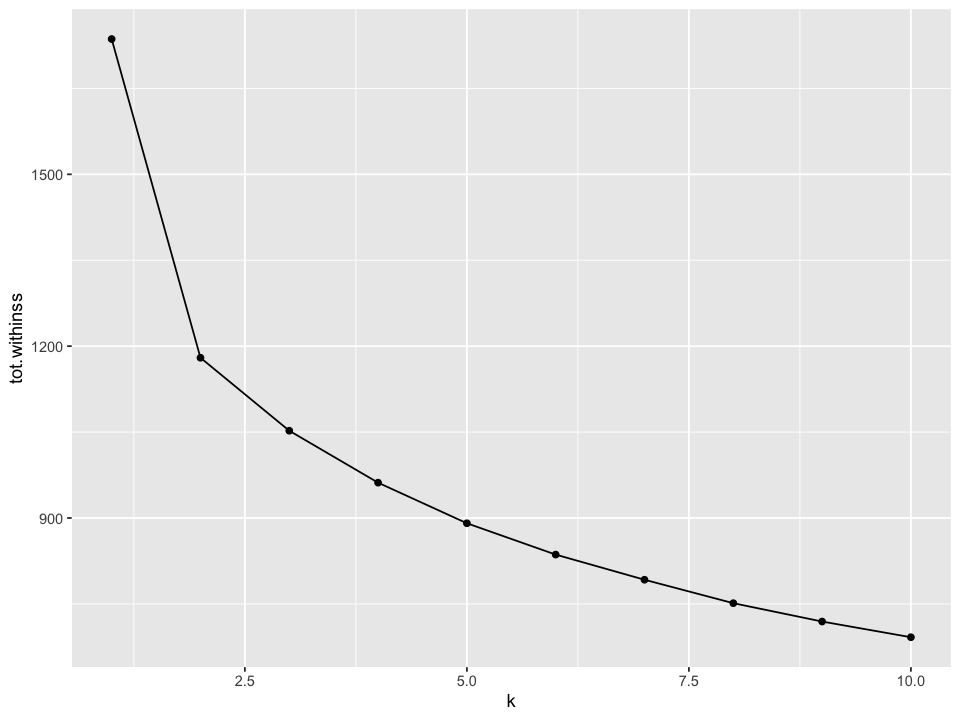

In [27]:
#DON'T CHANGE THIS SEED VALUE
set.seed(2019)

# your code here
jp_elbow_stats = tibble(k = 1:10) %>%
  mutate(model = map(k, ~kmeans(jp_tourism, nstart = 10, .x)),
         glanced = map(model, glance)) %>%
            select(-model) %>%
            unnest(glanced) %>%
            ggplot(aes(x = k, y = tot.withinss)) +
            geom_point() + geom_line() 


jp_elbow_stats
message("Selecting k = 3 after looking at the chart...")

**Question 2.2**
<br> {points: 3}

From the elbow plot above, which K should you choose? Explain why you chose that K.

#### Response:

I selected `k = 3`. The selection of this value is subjective, but it seems like the difference in `tot.withinss` from `k = 3` to `k = 4` is far lower than from `k = 2` to `k = 3`. I could have selected `k = 2`; however, I felt that the slope between `k = 2` and `k = 3` was sufficient enough to warrant including the latter point.

**Question 2.3**
<br> {points: 3}

Run kmeans (don't forget `nstart`) again, with the optimal K, and then use the `augment` function to get the cluster assignments for each point. Name the data frame `cluster_assignments`.

In [26]:
#DONT CHANGE THIS SEED VALUE
set.seed(2019)

# your code here
cluster_assignments = jp_tourism %>%
    kmeans(nstart = 10, centers = 3) %>%
    augment(jp_tourism)
head(cluster_assignments)

Category.1,Category.2,Category.3,Category.4,Category.5,Category.6,Category.7,Category.8,Category.9,Category.10,.cluster
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.93,1.80,2.29,0.62,0.80,2.42,3.19,2.79,1.82,2.42,1
1.02,2.20,2.66,0.64,1.42,3.18,3.21,2.63,1.86,2.32,1
1.22,0.80,0.54,0.53,0.24,1.54,3.18,2.80,1.31,2.50,2
0.45,1.80,0.29,0.57,0.46,1.52,3.18,2.96,1.57,2.86,2
0.51,1.20,1.18,0.57,1.54,2.02,3.18,2.78,1.18,2.54,3
0.99,1.28,0.72,0.27,0.74,1.26,3.17,2.89,1.66,3.66,2


For the following 2 questions use the following plot as reference.

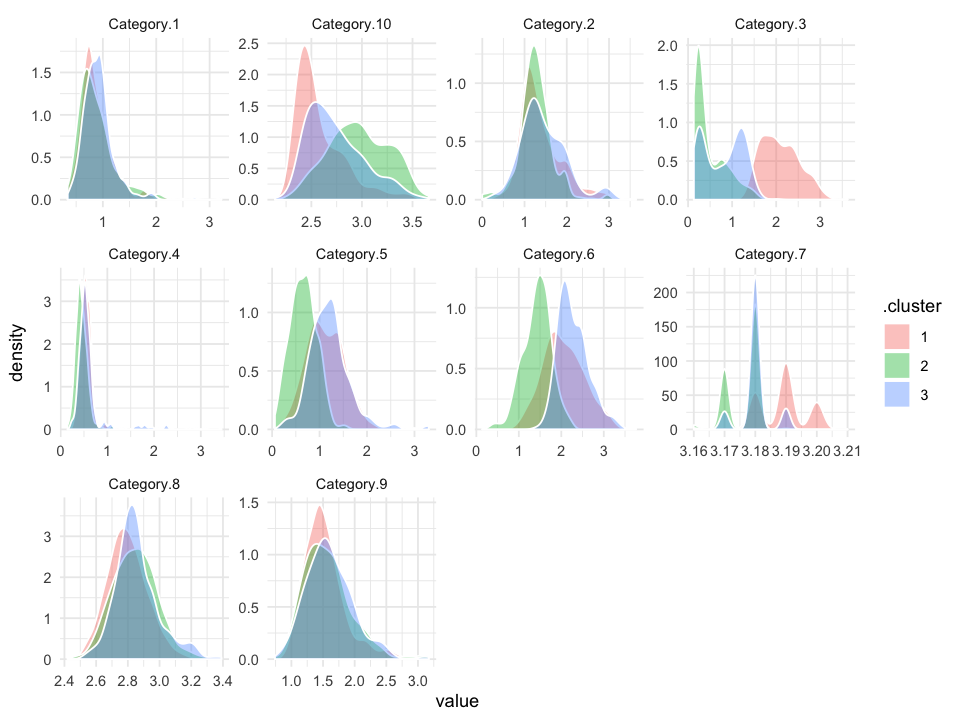

In [28]:
options(repr.plot.height = 6, repr.plot.width = 8)
cluster_assignments %>%
    gather(key = 'category', value = 'value', -.cluster) %>%
    ggplot(aes(value, fill = .cluster)) +
        geom_density(alpha = 0.4, colour = 'white') +
        facet_wrap(~ category, scales = 'free') +
        theme_minimal()

**Question 2.4**
<br> {points: 3}

From the plots above, which categories might we hypothesize are driving the clustering? (i.e., are useful to distinguish between the type of tourists?) And explain why you think so for each category? We list the table of the categories below. 

- Category 1 : Average user feedback on art galleries 
- Category 2 : Average user feedback on dance clubs 
- Category 3 : Average user feedback on juice bars 
- Category 4 : Average user feedback on restaurants 
- Category 5 : Average user feedback on museums 
- Category 6 : Average user feedback on resorts 
- Category 7 : Average user feedback on parks/picnic spots 
- Category 8 : Average user feedback on beaches 
- Category 9 : Average user feedback on theaters 
- Category 10 : Average user feedback on religious institutions

Looking at the matrix in 2.3, it seems that categories `3`, `5`, `6`, `7`, and `10` are driving the clustering.

Full disclosure: I have never been to Japan nor am I familiar with Japanese tourism.

With that said, I would hyphothesize that visiters are the most likely to visit the five categories seen above and have different opinionated views. For instance, visitors that visit juice bars either hate it or are indifferent.

This is in contrast to places like restaurants or beaches, where everyone shares the same opinion on the category.

**Question 2.5**
<br> {points: 3}

Discuss one disadvantage of not being able to visualize the clusters when dealing with multidimensional data. 

It is difficult to visualize how clusters of data behave across different categories. 